# Google news extractn

In [ ]:
import feedparser
import pandas as pd
from urllib.parse import urlparse

# googlenews rss feed for stock market news 
rss_url = "https://news.google.com/rss/search?q=stock+market&hl=en-US&gl=US&ceid=US:en"

# Parse rss feed
feed = feedparser.parse(rss_url)

# Extract headlines, links, sources, and dates
news_data = []
for entry in feed.entries:
    parsed_url = urlparse(entry.link)
    source_site = parsed_url.netloc  # Extract domain name (source site)
    
    # get publication date (if available)
    published_date = entry.get("published", "No date available")

    news_data.append({
        "Headline": entry.title,
        "Link": entry.link,
        "Source": source_site,
        "Published Date": published_date
    })

#dataframeconversn
news_df = pd.DataFrame(news_data)

#csvsave
news_df.to_csv("google_news_data.csv", index=False)

#summary
print(f"Total articles extracted: {len(news_df)}")
print("Unique sources found:", news_df['Source'].nunique())
print(news_df['Source'].value_counts())  # count of articles per source
print(news_df.head())

# Twtr scrapping

In [ ]:
import time
import datetime
from collections import Counter
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from plyer import notification

# Setup chromedriver
chrome_options = Options()
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--window-size=1920,1080")
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

# basis of twitter data extraction
influential_accounts = [
    "KobeissiLetter", "Barchart", "fxhedgers", "unusual_whales",
    "TaviCosta", "LynAldenContact", "macroalf", "SawyerMerritt",
    "WatcherGuru", "TheTerminal_", "StockMKTNewz", "leadlagreport",
    "GameofTrades_", "zerohedge", "charliebilello", "federalreserve", "Stocktwits"
]

market_keywords = [
    "stock market", "crash", "sell-off", "recession", "inflation",
    "interest rates", "liquidity", "quantitative tightening", "Federal Reserve",
    "volatility", "unemployment", "GDP", "housing market", "oil prices"
]

def send_desktop_notification(title, message):
    notification.notify(
        title=title,
        message=message,
        timeout=10
    )

#scrapetweets based on search query
def scrape_twitter(query):
    twitter_url = f"https://twitter.com/search?q={query.replace(' ', '%20')}&src=typed_query&f=live"
    driver.get(twitter_url)
    time.sleep(5)

    tweets_data = []
    last_height = driver.execute_script("return document.body.scrollHeight")
    scroll_attempts = 0
    start_time = datetime.datetime.now()
    timeout = 60

    while (datetime.datetime.now() - start_time).seconds < timeout:
        old_tweets = len(tweets_data)
        driver.execute_script("window.scrollBy(0, 2000);")
        time.sleep(1.5)
        tweets = driver.find_elements(By.CSS_SELECTOR, "article[data-testid='tweet']")

        for tweet in tweets:
            try:
                content = tweet.find_element(By.XPATH, ".//div[@lang]").text
                timestamp = tweet.find_element(By.XPATH, ".//time").get_attribute("datetime")
                tweets_data.append({"timestamp": timestamp, "content": content})
            except:
                continue

        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            scroll_attempts += 1
            if scroll_attempts >= 5:
                break
        else:
            scroll_attempts = 0
        last_height = new_height

    return tweets_data

# csv data save
def save_tweet_data():
    all_tweets = []
    for account in influential_accounts:
        all_tweets.extend(scrape_twitter(f"from:{account}"))
    
    
    tweets_df = pd.DataFrame(all_tweets)
    tweets_df.to_csv("scraped_tweet_data.csv", index=False)
    print("Tweet data saved to scraped_tweet_data.csv")


# funcn for detect keyword frequency in scraped data
def detect_keyword_frequency(tweets, keywords):
    # Ensure all tweet content is a string before joining
    all_text = " ".join([str(tweet["content"]) for tweet in tweets if isinstance(tweet["content"], str)])
    word_counts = Counter(all_text.lower().split())
    return {word: word_counts[word] for word in keywords if word in word_counts}


# Monitor market
def monitor_market():
    # Save tweet data
    save_tweet_data()

    # savetweetdata
    tweets_df = pd.read_csv("scraped_tweet_data.csv")
    all_tweets = [{"timestamp": row["timestamp"], "content": row["content"]} for index, row in tweets_df.iterrows()]

    # Detect keyword frequency
    keyword_frequencies = detect_keyword_frequency(all_tweets, market_keywords)
    df = pd.DataFrame({"Keyword": keyword_frequencies.keys(), "Frequency": keyword_frequencies.values()})
    df.to_csv("twitter_market_sentiment_alerts.csv", index=False)
    
    if any(count >= 5 for count in keyword_frequencies.values()):
        send_desktop_notification("Market Alert!", str(keyword_frequencies))

    print("Data saved to twitter_market_sentiment_alerts.csv")
    print("Keyword Alerts:", keyword_frequencies)

monitor_market()
driver.quit()


# news data cleaning

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer



df = pd.read_csv("google_news_data.csv")

# fordroppinanyduplicates
df = df.drop_duplicates(subset=["Headline"])

# Removemissinvalues
df = df.dropna()

# Convertolowercase
df["Headline"] = df["Headline"].str.lower()

# Funcn for clean text
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Removespecialcharacters
    text = re.sub(r'\s+', ' ', text)  # Removeextraspaces
    return text.strip()

df["Headline"] = df["Headline"].apply(clean_text)

# Tokenization & Stopword Removal
stop_words = set(stopwords.words("english"))
df["Tokens"] = df["Headline"].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df["Lemmatized"] = df["Tokens"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Savecleanupdata
df.to_csv("cleaned_google_news.csv", index=False)


print(df.head())

# sentiment analysis of google data

In [ ]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

news_df = pd.read_csv("cleaned_google_news.csv")

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    """Compute VADER sentiment score."""
    return sia.polarity_scores(text)['compound']

def get_textblob_sentiment(text):
    """Compute TextBlob sentiment score."""
    return TextBlob(text).sentiment.polarity

# ApplyVADER
news_df["VADER_Sentiment"] = news_df["Headline"].apply(get_vader_sentiment)
news_df["TextBlob_Sentiment"] = news_df["Headline"].apply(get_textblob_sentiment)

# AverageSentmnt
news_df["Avg_Sentiment"] = (news_df["VADER_Sentiment"] + news_df["TextBlob_Sentiment"]) / 2

# CategorizingSentiment
news_df["Sentiment_Label"] = news_df["Avg_Sentiment"].apply(lambda x: "Positive" if x > 0.05 else ("Negative" if x < -0.05 else "Neutral"))

# Save 
news_df.to_csv("google_news_sentiment.csv", index=False)

print("Sentiment analysis completed and saved to google_news_sentiment.csv")

# Twitter data sentiment analysis

In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

#gettingoursentiment scores
def get_sentiment_score(text):
    # Using VADER
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']  #compound score is overall sentiment

#load data
scraped_tweet_df = pd.read_csv("scraped_tweet_data.csv")

#calculate sentiment scores 
scraped_tweet_df['sentiment_score'] = scraped_tweet_df['content'].apply(lambda x: get_sentiment_score(str(x)))

# Save 
scraped_tweet_df.to_csv("scraped_tweet_data_with_sentiment.csv", index=False)

print("Sentiment analysis complete for scraped tweets. Results saved to 'scraped_tweet_data_with_sentiment.csv'.")


# Against Market Google and twiiter


#daily google news vs market

In [ ]:
import pandas as pd
import yfinance as yf
from datetime import datetime

#loaddata
sentiment_df = pd.read_csv("google_news_sentiment.csv")

#convertpublishdate to datetime format
sentiment_df["Published Date"] = pd.to_datetime(sentiment_df["Published Date"], utc=True)

#get historical sp500 data
ticker = "^GSPC"  # S&P 500 index
start_date = sentiment_df["Published Date"].min().strftime("%Y-%m-%d")
end_date = sentiment_df["Published Date"].max().strftime("%Y-%m-%d")
sp500_data = yf.download(ticker, start=start_date, end=end_date)

#flatten multindex columns if req
if isinstance(sp500_data.columns, pd.MultiIndex):
    sp500_data.columns = sp500_data.columns.get_level_values(0)

# Debug print for sp 500 data
print("Raw S&P500 Data Columns:", sp500_data.columns)
print("Raw S&P500 Data Index Names:", sp500_data.index.names)

# aggregate sentiment scores by date
sentiment_daily = sentiment_df.groupby(sentiment_df["Published Date"].dt.date)["Avg_Sentiment"].mean()
sentiment_daily.index = pd.to_datetime(sentiment_daily.index)

#debug print for daily sentiment
print("Sentiment Daily Index Names:", getattr(sentiment_daily.index, 'names', None))
print("First few rows of sentiment_daily:")
print(sentiment_daily.head())

# convert sp500_data index to datetime with UTC, then to date objects
sp500_data.index = pd.to_datetime(sp500_data.index, utc=True).date

#calc daily change
sp500_data["Price Change %"] = sp500_data["Close"].pct_change()

#reset index to bring the date index into a column
sp500_data = sp500_data.reset_index()

# the date column might be named "index" if the index had no name
if "index" in sp500_data.columns:
    sp500_data = sp500_data.rename(columns={"index": "Date"})

# Convert'Date' column to date objects and set as index
sp500_data["Date"] = pd.to_datetime(sp500_data["Date"]).dt.date
sp500_data.set_index("Date", inplace=True)

# Debug print for sp500_data
print("First few rows of sp500_data:")
print(sp500_data.head())

#merge the datasets on their date index
merged_df = pd.merge(sp500_data, sentiment_daily, left_index=True, right_index=True, how="inner")

#corr-------------------------------
correlation = merged_df[["Close", "Avg_Sentiment"]].corr()

# Displaydata merged
print("Merged Data (first few rows):")
print(merged_df.head())
print("Correlation between Close and Avg_Sentiment:")
print(correlation)

#########################
merged_df.to_csv("sentiment_vs_market_google.csv")
print("Analysis saved to 'sentiment_vs_market_google.csv'")

#hourly

In [ ]:
import pandas as pd
import yfinance as yf
from pandas.tseries.offsets import BDay
from datetime import datetime, time


sentiment_df = pd.read_csv("google_news_sentiment.csv")

#cnvert to Eastern Time (market timezone)
sentiment_df["Published Date"] = pd.to_datetime(sentiment_df["Published Date"], utc=True).dt.tz_convert('America/New_York')

#extractinmarket data with pre/post-market
ticker = "^GSPC"
start_date = sentiment_df["Published Date"].min().strftime("%Y-%m-%d")
end_date = (sentiment_df["Published Date"].max() + BDay(1)).strftime("%Y-%m-%d")

#1h data including pre/post-market
sp500_data = yf.download(ticker, start=start_date, end=end_date, interval='1h', prepost=True)

#cnvert market data index to Eastern Time
sp500_data.index = sp500_data.index.tz_convert('America/New_York')

#ensuring correct column namesfor multi-indexed
if isinstance(sp500_data.columns, pd.MultiIndex):
    sp500_data.columns = sp500_data.columns.droplevel(1)  # Fix column names

#defining market hours
market_open = time(9, 30)
market_close = time(16, 0)

def adjust_sentiment_time(ts):
    """Shift after-hours sentiment to next market open"""
    ts = pd.Timestamp(ts).tz_convert('America/New_York')
    
    if (ts.time() > market_close) or (ts.time() < market_open) or (ts.weekday() >= 5):
        next_open = ts + BDay(1)
        return next_open.normalize() + pd.Timedelta(hours=9, minutes=30)
    elif ts.time() < market_open:
        return ts.normalize() + pd.Timedelta(hours=9, minutes=30)
    return ts

#applyin time adjustment to sentiment data
sentiment_df["Adjusted Hour"] = sentiment_df["Published Date"].apply(adjust_sentiment_time)

#cvnrt to proper timezone-aware datetime (FIXED)
sentiment_df["Adjusted Hour"] = pd.to_datetime(sentiment_df["Adjusted Hour"]).dt.tz_convert('America/New_York')

# aggregate sentiment to adjusted hours
sentiment_hourly = sentiment_df.groupby(pd.Grouper(key="Adjusted Hour", freq='h'))["Avg_Sentiment"].mean()

# Calculate price changes forward-looking
sp500_data["Next Hour Change %"] = sp500_data["Close"].pct_change().shift(-1)

#merge data using **nearest** timestamps to avoid null values
merged_df = pd.merge_asof(
    sp500_data[["Close", "Next Hour Change %"]].sort_index(),
    sentiment_hourly.sort_index(),
    left_index=True,
    right_index=True,
    direction="backward"
)

# Drop NaNs
merged_df.dropna(inplace=True)

# Filter to market hours only
merged_df.index = merged_df.index.tz_convert('America/New_York').tz_localize(None)
merged_df = merged_df.between_time(market_open, market_close)

# Calc correlation
correlation = merged_df[["Next Hour Change %", "Avg_Sentiment"]].corr()

# Sort for latest data first, that is descend.
merged_df = merged_df.sort_index(ascending=False)

print("hourly_sentiment_vs_market_google:")
print(correlation)
print("\nSample Data:")
print(merged_df.head())

#savingg
merged_df.to_csv("hourly_sentiment_vs_market_google.csv")


#twitter hourly

In [ ]:
import pandas as pd
import yfinance as yf
from pandas.tseries.offsets import BDay
from datetime import datetime, time


tweet_sentiment_df = pd.read_csv("scraped_tweet_data_with_sentiment.csv")

# Cnvert to Est time zone
tweet_sentiment_df["timestamp"] = pd.to_datetime(tweet_sentiment_df["timestamp"], utc=True).dt.tz_convert('America/New_York')

#market data for the last 60 days
ticker = "^GSPC"  # S&P 500 index as an example
end_date = datetime.now()  #current date==end date
start_date = end_date - pd.Timedelta(days=60)  #days limit

#1h data including pre/post-market
sp500_data = yf.download(ticker, start=start_date, end=end_date, interval='1h', prepost=True)

#chnge market data index to eastern Timeee
sp500_data.index = sp500_data.index.tz_convert('America/New_York')

#correct column names for multi-indexed
if isinstance(sp500_data.columns, pd.MultiIndex):
    sp500_data.columns = sp500_data.columns.droplevel(1)  # fix colomn names

#market hours
market_open = time(9, 30)
market_close = time(16, 0)

def adjust_sentiment_time(ts):
    """Shift after-hours sentiment to next market open"""
    ts = pd.Timestamp(ts).tz_convert('America/New_York')
    
    if (ts.time() > market_close) or (ts.time() < market_open) or (ts.weekday() >= 5):
        next_open = ts + BDay(1)
        return next_open.normalize() + pd.Timedelta(hours=9, minutes=30)
    elif ts.time() < market_open:
        return ts.normalize() + pd.Timedelta(hours=9, minutes=30)
    return ts

# Apply timeadjustment to sentiment data
tweet_sentiment_df["Adjusted Hour"] = tweet_sentiment_df["timestamp"].apply(adjust_sentiment_time)

# Convert to proper timezone-aware datetime (FIXED)
tweet_sentiment_df["Adjusted Hour"] = pd.to_datetime(tweet_sentiment_df["Adjusted Hour"]).dt.tz_convert('America/New_York')

#agg sent to adjusted hrs
sentiment_hourly = tweet_sentiment_df.groupby(pd.Grouper(key="Adjusted Hour", freq='h'))["sentiment_score"].mean()

#price changes forward-looking (next hour)
sp500_data["Next Hour Change %"] = sp500_data["Close"].pct_change().shift(-1)

#merge to nearest for avoiding null
merged_df = pd.merge_asof(
    sp500_data[["Close", "Next Hour Change %"]].sort_index(),
    sentiment_hourly.sort_index(),
    left_index=True,
    right_index=True,
    direction="backward"
)

#dropnulls
merged_df.dropna(inplace=True)

#filterformakrkethours
merged_df.index = merged_df.index.tz_convert('America/New_York').tz_localize(None)
merged_df = merged_df.between_time(market_open, market_close)

#corr cal.
correlation = merged_df[["Next Hour Change %", "sentiment_score"]].corr()

#latest sort
merged_df = merged_df.sort_index(ascending=False)

# Print correlation and sample data
print("hourly_sentiment_vs_market_tweets:")
print(correlation)
print("\nSample Data:")
print(merged_df.head())

# Save
merged_df.to_csv("hourly_sentiment_vs_market_tweets.csv")
print("Analysis saved to 'hourly_sentiment_vs_market_tweets.csv'")


#dailybasis

In [ ]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta


tweet_sentiment_df = pd.read_csv("scraped_tweet_data_with_sentiment.csv")

# convert timestamp to datetime format
tweet_sentiment_df["timestamp"] = pd.to_datetime(tweet_sentiment_df["timestamp"], utc=True)

# Get historical S&P 500
ticker = "^GSPC"  # S&P 500 index 
start_date = tweet_sentiment_df["timestamp"].min().strftime("%Y-%m-%d")
end_date = tweet_sentiment_df["timestamp"].max().strftime("%Y-%m-%d")


sp500_data = yf.download(ticker, start=start_date, end=end_date)

#pint sp500 data
print(sp500_data.columns)

#converttt index to datetime
sp500_data.index = pd.to_datetime(sp500_data.index, utc=True)

#cal. daily percentage change
sp500_data["Price Change %"] = sp500_data["Close"].pct_change() * 100  # Percentage change in stock price

#Aggregate tweet sentiment scores by date (mean sentiment per day)
sentiment_daily = tweet_sentiment_df.groupby(tweet_sentiment_df["timestamp"].dt.date)["sentiment_score"].mean()

# Convert sentimentdaily index to datetime format
sentiment_daily.index = pd.to_datetime(sentiment_daily.index, utc=True)

#-----------Merging sentiment data with market data---------------------
# Flatten multiIndx by resetting it for sp 500 data
sp500_data = sp500_data.reset_index()

# rename columns to remove MultiIndex
sp500_data.columns = ['Date'] + [col[0] for col in sp500_data.columns[1:]]

#convertt 'Date' to datetime and set as index for sp500 data
sp500_data["Date"] = pd.to_datetime(sp500_data["Date"]).dt.date
sp500_data.set_index("Date", inplace=True)

# Ensuring our sentiment data index in the correct format (datetime.date)
sentiment_daily.index = pd.to_datetime(sentiment_daily.index).date

# Mergedatasets on the 'Date' index
merged_df = pd.merge(sp500_data, sentiment_daily, left_index=True, right_index=True, how="inner")

#corr compute------------------
correlation = merged_df[["Close", "sentiment_score"]].corr()

# Display corr and data
print(merged_df.head())
print("Correlation between sentiment and market price change:")
print(correlation)

#saving our data obtained
merged_df.to_csv("sentiment_vs_market_tweets.csv")
print("Analysis saved to 'sentiment_vs_market_tweets.csv'")

# dashboard

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns




google_news_sentiment = pd.read_csv("google_news_sentiment.csv")
#cnvrt "Published Date" to datetime
google_news_sentiment["Published Date"] = pd.to_datetime(google_news_sentiment["Published Date"], errors='coerce')

# load hourly google vs market data
hourly_sentiment_vs_market_google = pd.read_csv("hourly_sentiment_vs_market_google.csv")
hourly_sentiment_vs_market_google["Datetime"] = pd.to_datetime(hourly_sentiment_vs_market_google["Datetime"], errors='coerce')
# Rename sentiment column to google news setiment
hourly_sentiment_vs_market_google.rename(columns={"Avg_Sentiment": "Google_News_Sentiment"}, inplace=True)

#Hourly Sentiment vs. Market Data for Twitter
hourly_sentiment_vs_market_tweets = pd.read_csv("hourly_sentiment_vs_market_tweets.csv")
hourly_sentiment_vs_market_tweets["Datetime"] = pd.to_datetime(hourly_sentiment_vs_market_tweets["Datetime"], errors='coerce')
# Rename sentiment column to twitter sentimnt
hourly_sentiment_vs_market_tweets.rename(columns={"sentiment_score": "Twitter_Sentiment"}, inplace=True)

#load scraped tweet data with sentmnt
scraped_tweet_sentiment = pd.read_csv("scraped_tweet_data_with_sentiment.csv")
scraped_tweet_sentiment["timestamp"] = pd.to_datetime(scraped_tweet_sentiment["timestamp"], errors='coerce')

# Load daily google sentmnt vs market data
#the first column is the date index. Parse dates and use that as index.
high_corr_google_sentiment = pd.read_csv("sentiment_vs_market_google.csv", index_col=0, parse_dates=True)
high_corr_google_sentiment.rename(columns={"Avg_Sentiment": "Google_High_Corr_Sentiment"}, inplace=True)


##-------------- Merge Hourly Sentiment Data----------


# mergehourly sentiment from Google News and Twitter on the "Datetime" column (outer join)
merged_hourly_sentiment = pd.merge(hourly_sentiment_vs_market_google, 
                                   hourly_sentiment_vs_market_tweets[["Datetime", "Twitter_Sentiment"]],
                                   on="Datetime", 
                                   how="outer")

# Sort bydatetime
merged_hourly_sentiment = merged_hourly_sentiment.sort_values(by="Datetime")

# fillin missing market data ("Close" and "Next Hour Change %") with forward then backward fill
merged_hourly_sentiment["Close"].fillna(method="ffill", inplace=True)
merged_hourly_sentiment["Close"].fillna(method="bfill", inplace=True)
merged_hourly_sentiment["Next Hour Change %"].fillna(method="ffill", inplace=True)
merged_hourly_sentiment["Next Hour Change %"].fillna(method="bfill", inplace=True)

# -------------------------------
# aggregate daily sent.data


# Create a Date column from the Datetime column
merged_hourly_sentiment["Date"] = merged_hourly_sentiment["Datetime"].dt.date

# Aggregate daily values:
# - For sentiment: take the mean of Google News and Twitter sentiments
# - For market: take the last closing price and sum the next hour % change as a proxy for daily change
daily_sentiment = merged_hourly_sentiment.groupby("Date").agg({
    "Google_News_Sentiment": "mean",
    "Twitter_Sentiment": "mean",
    "Close": "last",
    "Next Hour Change %": "sum"
}).reset_index()

# Ensure the Date column is in datetime format
daily_sentiment["Date"] = pd.to_datetime(daily_sentiment["Date"])


#-------------------Merge with High-Correlation Google Sentiment Data


# Merge the high-correlation Google sentiment into our daily data using the Date as key.
daily_sentiment_merged = daily_sentiment.merge(
    high_corr_google_sentiment[["Google_High_Corr_Sentiment"]],
    left_on="Date", 
    right_index=True, 
    how="left"
)

# Fill any remaining missing values for high-correlation sentiment
daily_sentiment_merged["Google_High_Corr_Sentiment"].fillna(method="ffill", inplace=True)
daily_sentiment_merged["Google_High_Corr_Sentiment"].fillna(method="bfill", inplace=True)

#  Save merged daily sentiment data to CSV for later use
daily_sentiment_merged.to_csv("daily_sentiment_merged.csv", index=False)


In [1]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd


 #Load

daily_sentiment_merged = pd.read_csv("daily_sentiment_merged.csv")
daily_sentiment_merged["Date"] = pd.to_datetime(daily_sentiment_merged["Date"])


 #Create dashapp layout

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Market Sentiment Dashboard"),
    html.Div([
        html.Label("Select Date Range:"),
        dcc.DatePickerRange(
            id="date-picker",
            min_date_allowed=daily_sentiment_merged["Date"].min().date(),
            max_date_allowed=daily_sentiment_merged["Date"].max().date(),
            start_date=daily_sentiment_merged["Date"].min().date(),
            end_date=daily_sentiment_merged["Date"].max().date()
        )
    ], style={"margin": "20px"}),

    dcc.Graph(id="sentiment-trend"),
    dcc.Graph(id="dual-axis-plot"),
    dcc.Graph(id="scatter-plot"),
    dcc.Graph(id="sentiment-histogram"),
    dcc.Graph(id="heatmap")
])


#callback to Update Graphs

@app.callback(
    [Output("sentiment-trend", "figure"),
     Output("dual-axis-plot", "figure"),
     Output("scatter-plot", "figure"),
     Output("sentiment-histogram", "figure"),
     Output("heatmap", "figure")],
    [Input("date-picker", "start_date"),
     Input("date-picker", "end_date")]
)
def update_graphs(start_date, end_date):
    #filter dataframe based on selected date range
    mask = (daily_sentiment_merged["Date"] >= start_date) & (daily_sentiment_merged["Date"] <= end_date)
    filtered_df = daily_sentiment_merged.loc[mask]
    
    # --- Graph : Daily Sentiment Trends
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(
        x=filtered_df["Date"],
        y=filtered_df["Google_News_Sentiment"],
        mode='lines+markers',
        name='Google News Sentiment',
        line=dict(color='blue')
    ))
    fig1.add_trace(go.Scatter(
        x=filtered_df["Date"],
        y=filtered_df["Twitter_Sentiment"],
        mode='lines+markers',
        name='Twitter Sentiment',
        line=dict(color='orange')
    ))
    fig1.update_layout(
        title="Daily Sentiment Trends",
        xaxis_title="Date",
        yaxis_title="Sentiment Score",
        hovermode="x unified"
    )
    
    # --------------- Graph: dual-Axis Plot: sentiment vs. Market 
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(
        x=filtered_df["Date"],
        y=filtered_df["Google_News_Sentiment"],
        mode='lines+markers',
        name='Google News Sentiment',
        line=dict(color='blue')
    ))
    fig2.add_trace(go.Scatter(
        x=filtered_df["Date"],
        y=filtered_df["Twitter_Sentiment"],
        mode='lines+markers',
        name='Twitter Sentiment',
        line=dict(color='orange')
    ))
    fig2.add_trace(go.Scatter(
        x=filtered_df["Date"],
        y=filtered_df["Next Hour Change %"],
        mode='lines+markers',
        name='Market Change %',
        line=dict(color='red'),
        yaxis="y2"
    ))
    fig2.update_layout(
        title="Daily Sentiment vs. Market Movement",
        xaxis_title="Date",
        yaxis=dict(title="Sentiment Score", titlefont=dict(color="blue"), tickfont=dict(color="blue")),
        yaxis2=dict(title="Market Change %", overlaying="y", side="right", 
                    titlefont=dict(color="red"), tickfont=dict(color="red")),
        hovermode="x unified"
    )
    
    # --\------- Graph : Scatter Plot:google high corr vs. Market Change 
    fig3 = go.Figure()
    fig3.add_trace(go.Scatter(
        x=filtered_df["Google_High_Corr_Sentiment"],
        y=filtered_df["Next Hour Change %"],
        mode='markers',
        marker=dict(color='green', size=10),
        name="Google_High_Corr_Sentiment vs Market Change"
    ))
    fig3.update_layout(
        title="Scatter Plot: Google_High_Corr_Sentiment vs. Market Change %",
        xaxis_title="Google_High_Corr_Sentiment",
        yaxis_title="Market Change %",
        hovermode="closest"
    )
    
    # ----------------- Graph : Histogram: sentiment score distrbtn
    fig4 = go.Figure()
    fig4.add_trace(go.Histogram(
        x=filtered_df["Google_News_Sentiment"],
        nbinsx=20,
        name="Google News Sentiment",
        marker_color='blue',
        opacity=0.7
    ))
    fig4.add_trace(go.Histogram(
        x=filtered_df["Twitter_Sentiment"],
        nbinsx=20,
        name="Twitter Sentiment",
        marker_color='orange',
        opacity=0.7
    ))
    fig4.update_layout(
        title="Histogram: Sentiment Score Distributions",
        xaxis_title="Sentiment Score",
        yaxis_title="Count",
        barmode="overlay",
        hovermode="closest"
    )
    
    # ------------------- Graph : Correlation Heatmap
    # computin the correlation matrix for selected columns
    corr_cols = ["Google_News_Sentiment", "Twitter_Sentiment", "Next Hour Change %", "Google_High_Corr_Sentiment"]
    corr_matrix = filtered_df[corr_cols].corr()
    fig5 = px.imshow(corr_matrix,
                     text_auto=True,
                     color_continuous_scale='RdBu',
                     title="Correlation Heatmap: Sentiment vs Market Movement")
    fig5.update_layout(hovermode="closest")
    
    return fig1, fig2, fig3, fig4, fig5


#Run dAshApp

if __name__ == '__main__':
    app.run(debug=True)


# SEC Fillings from FRED

In [ ]:
import requests
import time
import pandas as pd
from datetime import datetime

#List of CIKs for multiple companies
CIK_LIST = [
    "0000320193", "0000789019", "0001652044", "0001018724", "0001045810",
    "0001326801", "0001067983", "0001318605", "0000731766", "0000034088",
    "0000200406", "0000019617", "0001403161", "0000080424", "0001141391",
    "0000354950", "0000093410", "0000310158", "0001551152", "0000059478",
    "0000021344", "0000077476", "0001730168", "0001744489", "0000078003",
    "0000070858", "0000858877", "0000796343", "0001065280", "0001108524",
    "0001166691", "0001341439", "0000063908", "0000909832", "0000050863",
    "0000732712", "0000732717", "0000001800", "0000097745", "0000313546",
    "0000320187", "0000318154", "0000097476", "0001283699", "0000773840",
    "0001613103", "0000804328", "0000100885", "0000018230", "0000886982"
    
    
]

#sec api 
SEC_API_URL_TEMPLATE = "https://data.sec.gov/api/xbrl/companyfacts/CIK{CIK}.json"

#headers to avoid being blocked
HEADERS = {
    "User-Agent": "krishnabarai (karishna.barai@email.com)",  
    "Accept-Encoding": "gzip, deflate",
    "Accept": "application/json",
    "Connection": "keep-alive",
}

#function to fetch data for a specific company
def get_sec_data(cik):
    SEC_API_URL = SEC_API_URL_TEMPLATE.format(CIK=cik)
    print(f" Fetching data for CIK: {cik}")
    time.sleep(5)  #to prevent rate limits

    response = requests.get(SEC_API_URL, headers=HEADERS)

    if response.status_code == 403:
        print(" SEC is blocking us! Try using a VPN or waiting.")
        return None
    elif response.status_code != 200:
        print(f" Unexpected status code: {response.status_code}")
        return None
    return response.json()

#a list to store all filings data
all_filings_data = []

#Iterate over all CIKs in the list
for cik in CIK_LIST:
    sec_data = get_sec_data(cik)
    
    if sec_data:
        us_gaap_filings = sec_data.get("facts", {}).get("us-gaap", {})
        dei_filings = sec_data.get("facts", {}).get("dei", {})
        
        # Extract data from 'us-gaap' section
        for key, value in us_gaap_filings.items():
            text_to_save = str(value.get('units', '')) + str(value.get('val', ''))
            all_filings_data.append({
                "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                "cik": cik,
                "section": "us-gaap",
                "key": key,
                "units": value.get('units', ''),
                "value": value.get('val', ''),
                "text": text_to_save
            })
        
        #extract data from 'dei' section
        for key, value in dei_filings.items():
            text_to_save = str(value.get('units', '')) + str(value.get('val', ''))
            all_filings_data.append({
                "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                "cik": cik,
                "section": "dei",
                "key": key,
                "units": value.get('units', ''),
                "value": value.get('val', ''),
                "text": text_to_save
            })
    
    print(f"Data for CIK {cik} processed.")

# Save csv
df = pd.DataFrame(all_filings_data)
df.to_csv("sec_earnings_transcripts.csv", mode='a', header=False, index=False)

print(f" All data saved to 'sec_earnings_transcripts.csv'. Total filings collected: {len(all_filings_data)}.")


In [ ]:
#alerts

In [ ]:
import pandas as pd
import ast
import numpy as np

#optimized config
RISK_CONFIG = {
    'value_thresholds': {
        'default': 4_886_000_000,  # 75th %ile
        'AccountsPayable': 8_000_000_000,
        'Revenue': 15_000_000_000,
        'Cash': 5_000_000_000
    },
    
    'drop_thresholds': {
        'min_quarters': 3,  #Req 3 consec drops
        'pct_drop': 0.5,    #50% drop from baseline
        'min_abs_drop': 1_000_000_000  # $1bill min
    },
    
    'negative_value': {
        'lower_bound': -1_000_000_000,  # Ignore values < -$1B as data errors
        'whitelist': ['TaxAssets', 'DeferredRevenue']
    }
}

# loadata
df = pd.read_csv("sec_earnings_transcripts.csv", 
                header=None,
                names=['Timestamp', 'CIK', 'Taxonomy', 'Account',
                       'USD_Data1', 'Unnamed', 'USD_Data2'])

# historical tracking with trend analysis
history = {}

def analyze_risks(row):
    try:
        account = row['Account']
        data = ast.literal_eval(row['USD_Data1'])
        values = [item['val'] for item in data['USD']]
        
        if not values:
            return None
            
        current_val = values[-1]
        key = (row['CIK'], account)
        prev_vals = history.get(key, [])
        
        alerts = []
        
        #High Value Check
        threshold = RISK_CONFIG['value_thresholds'].get(account, RISK_CONFIG['value_thresholds']['default'])
        if current_val > threshold:
            alerts.append(f'high_value (${current_val/1e9:.1f}B > ${threshold/1e9:.1f}B)')
            
        #Valid Negative Value Check
        if (current_val < RISK_CONFIG['negative_value']['lower_bound'] or 
            (current_val < 0 and account not in RISK_CONFIG['negative_value']['whitelist'])):
            alerts.append(f'invalid_negative (${current_val/1e6:.1f}M)')
            
        #Significant Drop Analysis
        if len(prev_vals) >= RISK_CONFIG['drop_thresholds']['min_quarters']:
            baseline = np.mean(prev_vals[:-RISK_CONFIG['drop_thresholds']['min_quarters']])
            current_avg = np.mean(prev_vals[-RISK_CONFIG['drop_thresholds']['min_quarters']:])
            
            pct_drop = (baseline - current_avg)/baseline if baseline != 0 else 0
            abs_drop = baseline - current_avg
            
            if (pct_drop >= RISK_CONFIG['drop_thresholds']['pct_drop'] and 
                abs_drop >= RISK_CONFIG['drop_thresholds']['min_abs_drop']):
                alerts.append(f'sustained_drop ({pct_drop:.0%} over {RISK_CONFIG["drop_thresholds"]["min_quarters"]}q)')
        
        # Update history (keep 8 quarters)
        history[key] = (prev_vals + [current_val])[-8:]
        
        return {
            'CIK': row['CIK'],
            'Account': account,
            'Value': current_val,
            'Alerts': ' | '.join(alerts) if alerts else None
        }
        
    except Exception as e:
        return {'CIK': row['CIK'], 'Error': str(e), 'Alerts': None}

#Process and filter
results = df.apply(analyze_risks, axis=1)
alerts_df = pd.DataFrame([r for r in results if r and r.get('Alerts')])

print(f"Final Alert Count: {len(alerts_df)}")
print("Alert Distribution:")
print(alerts_df['Alerts'].value_counts().head(10))

alerts_df.to_csv("strategic_sec_alerts.csv", index=False)        #  okk whatever this wil be the final code

In [ ]:
#vislztn

In [3]:
import pandas as pd
import plotly.express as px
from dash import Dash, dcc, html, Input, Output

#load and clean data
alerts = pd.read_csv("strategic_sec_alerts.csv")
alerts['Value'] = pd.to_numeric(alerts['Value'], errors='coerce').dropna()

#Value Distribution (Violin Plot)
violin_fig = px.violin(alerts,
                      y='Value',
                      box=True,
                      title='Financial Value Distribution',
                      hover_data=['Account', 'CIK'],
                      log_y=True)

#Account-wise Alert Count (Bar Chart)
bar_fig = px.bar(alerts['Account'].value_counts().reset_index(),
               x='Account',
               y='count',
               title='Alerts by Account Type',
               labels={'count': 'Number of Alerts'},
              color='Account')

#Alert Type Breakdown (Pie Chart)
pie_fig = px.pie(alerts['Alerts'].value_counts().reset_index(),
                names='Alerts',
                values='count',
                title='Alert Type Distribution',
                hole=0.3)

# create dashboard
app = Dash(__name__)

app.layout = html.Div([
    html.H1("SEC Risk Alert Dashboard", style={'textAlign': 'center', 'padding': '20px'}),
    
    html.Div([
        dcc.Graph(figure=violin_fig, style={'width': '80%', 'display': 'inline-block'}),
        dcc.Graph(figure=bar_fig, style={'width': '80%', 'display': 'inline-block'})
    ]),
    
    html.Div([
        dcc.Graph(figure=pie_fig, style={'height': '700px'})
    ]),
    
    html.Div([
        dcc.Dropdown(
            id='account-filter',
            options=[{'label': acc, 'value': acc} for acc in alerts['Account'].unique()],
            value=alerts['Account'].iloc[0],
            clearable=False,
            style={'width': '60%', 'margin': '20px auto'}
        ),
        dcc.Graph(id='account-details')
    ])
])

@app.callback(
    Output('account-details', 'figure'),
    Input('account-filter', 'value')
)
def update_account_view(selected_account):
    filtered = alerts[alerts['Account'] == selected_account]
    return px.scatter(filtered,
                    x='Value',
                    y='Alerts',
                    color='Alerts',
                    size='Value',
                    title=f'{selected_account} - Detailed View',
                    hover_data=['CIK'])

if __name__ == '__main__':
    app.run(debug=True, port=8050)

# MACRO DATA

In [ ]:
import pandas as pd
import pandas_datareader.data as web
import datetime

FRED_API_KEY = '5c52774c0b67b60a452745a9eb370165'  

# Expanded list of 50+ key macroeconomic indicators
MACRO_SERIES = {
    # GDP and Components
    'GDP': 'GDP',
    'GDPC1': 'GDPC1',  # Real GDP
    'GDPPOT': 'GDPPOT',  # Potential GDP
    'PCEC': 'PCEC',  # Personal Consumption Expenditures
    
    # Employment
    'UNRATE': 'UNRATE',  # Unemployment Rate
    'PAYEMS': 'PAYEMS',  # Nonfarm Payrolls
    'CE16OV': 'CE16OV',  # Civilian Employment
    'U6RATE': 'U6RATE',  # Underemployment Rate
    
    # Inflation
    'CPIAUCSL': 'CPIAUCSL',  # CPI All Items
    'PCEPI': 'PCEPI',  # PCE Price Index
    'PPIACO': 'PPIACO',  # Producer Price Index
    
    # Interest Rates
    'FEDFUNDS': 'FEDFUNDS',  # Federal Funds Rate
    'DGS10': 'DGS10',  # 10-Year Treasury Yield
    'DGS2': 'DGS2',  # 2-Year Treasury Yield
    
    # Housing
    'HOUST': 'HOUST',  # Housing Starts
    'CSUSHPINSA': 'CSUSHPINSA',  # Case-Shiller Home Price Index
    'MSPUS': 'MSPUS',  # Median Sales Price of Houses
    
    # Manufacturing
    'INDPRO': 'INDPRO',  # Industrial Production
    'TCU': 'TCU',  # Capacity Utilization
    'NEWORDER': 'NEWORDER',  # Manufacturers' New Orders
    
    # Consumer
    'RRSFS': 'RRSFS',  # Retail Sales
    'UMCSENT': 'UMCSENT',  # Consumer Sentiment
    
    # Trade
    'BOPGSTB': 'BOPGSTB',  # Trade Balance
    'EXPGS': 'EXPGS',  # Exports
    'IMPGS': 'IMPGS',  # Imports
    
    # Financial Markets
    'DJIA': 'DJIA',  # Dow Jones
    'SP500': 'SP500',  # S&P 500
    'VIXCLS': 'VIXCLS',  # VIX Index
    
    # Commodities
    'DCOILWTICO': 'DCOILWTICO',  # Oil Prices
    'GOLDAMGBD228NLBM': 'GOLDAMGBD228NLBM',  # Gold Prices
    
    # Government Finance
    'FYFSD': 'FYFSD',  # Federal Surplus/Deficit
    'GFDEBTN': 'GFDEBTN',  # Federal Debt
    
    # Banking
    'TOTCI': 'TOTCI',  # Commercial & Industrial Loans
    'M2SL': 'M2SL',  # Money Supply M2
    
    # International
    'DTWEXBGS': 'DTWEXBGS',  # US Dollar Index
    'DEXUSEU': 'DEXUSEU',  # USD/EUR Exchange Rate
    'DEXCHUS': 'DEXCHUS',  # USD/CNY Exchange Rate
    
    # Leading Indicators
    'USSLIND': 'USSLIND',  # Leading Economic Index
    'T10Y2Y': 'T10Y2Y',  # 10Y-2Y Yield Spread
}

def fetch_fred_data(series_dict, start_date='1970-01-01'):
    """Fetch macroeconomic data from FRED with error handling"""
    end_date = datetime.datetime.now().strftime('%Y-%m-%d')
    df = pd.DataFrame()
    fetched_series = []
    
    for name, code in series_dict.items():
        try:
            series = web.DataReader(code, 'fred', start_date, end_date)
            if not series.empty:
                #resample to monthly and forward fill missing values
                series = series.resample('M').last().ffill()
                df = pd.concat([df, series], axis=1)
                fetched_series.append((name, code))
                print(f" Success: {name} ({code})")
            else:
                print(f" Empty data: {name} ({code})")
        except Exception as e:
            print(f" Failed: {name} ({code}) - {str(e)}")
    
    # Create meaningful column names from fetched series only
    df.columns = [f"{name}_{code}" for name, code in fetched_series]
    
    # forward fill missing values and drop remaining NAs
    return df.ffill().dropna()

def save_macro_data(file_name='macro_data.csv'):
    """Save macro data to CSV with progress tracking"""
    print(" Fetching macroeconomic data from FRED...")
    macro_df = fetch_fred_data(MACRO_SERIES)
    
    # Add derived metrics
    macro_df['GDP_Growth_QoQ'] = macro_df['GDP_GDP'].pct_change(periods=1) * 100
    macro_df['CPI_YoY'] = macro_df['CPIAUCSL_CPIAUCSL'].pct_change(periods=12) * 100
    
    #saveed
    macro_df.to_csv(file_name)
    
    print(f"\n Successfully saved {len(macro_df.columns)} indicators")
    print(f" Date Range: {macro_df.index.min()} to {macro_df.index.max()}")
    print(f" Total Series: {len(macro_df.columns)}")
    print(f"File saved as: {file_name}")

if __name__ == '__main__':
    save_macro_data()

In [ ]:
#VISULAZTN

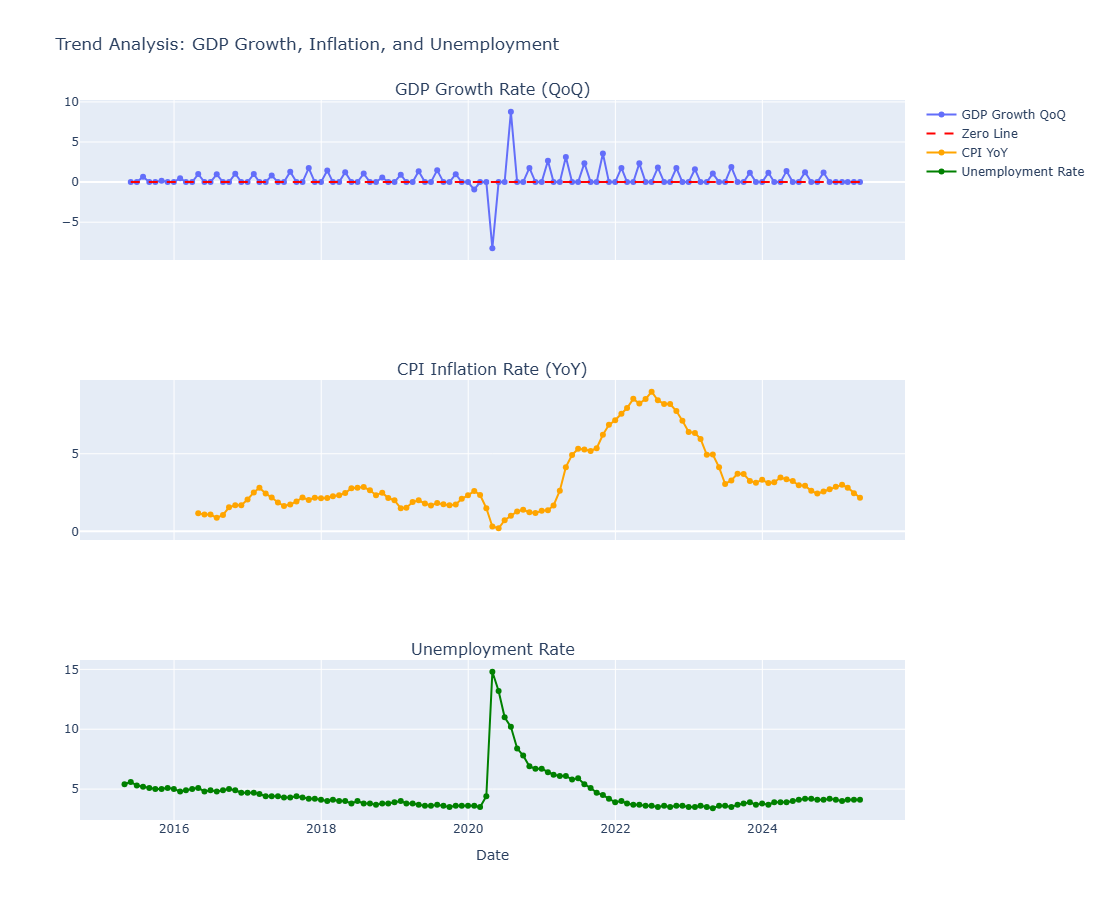

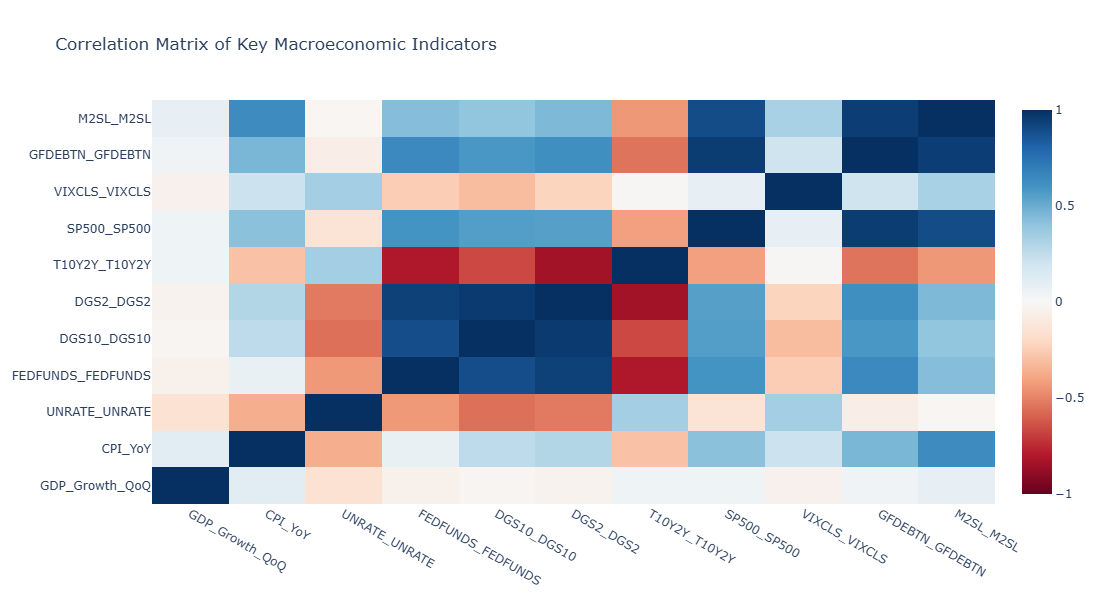

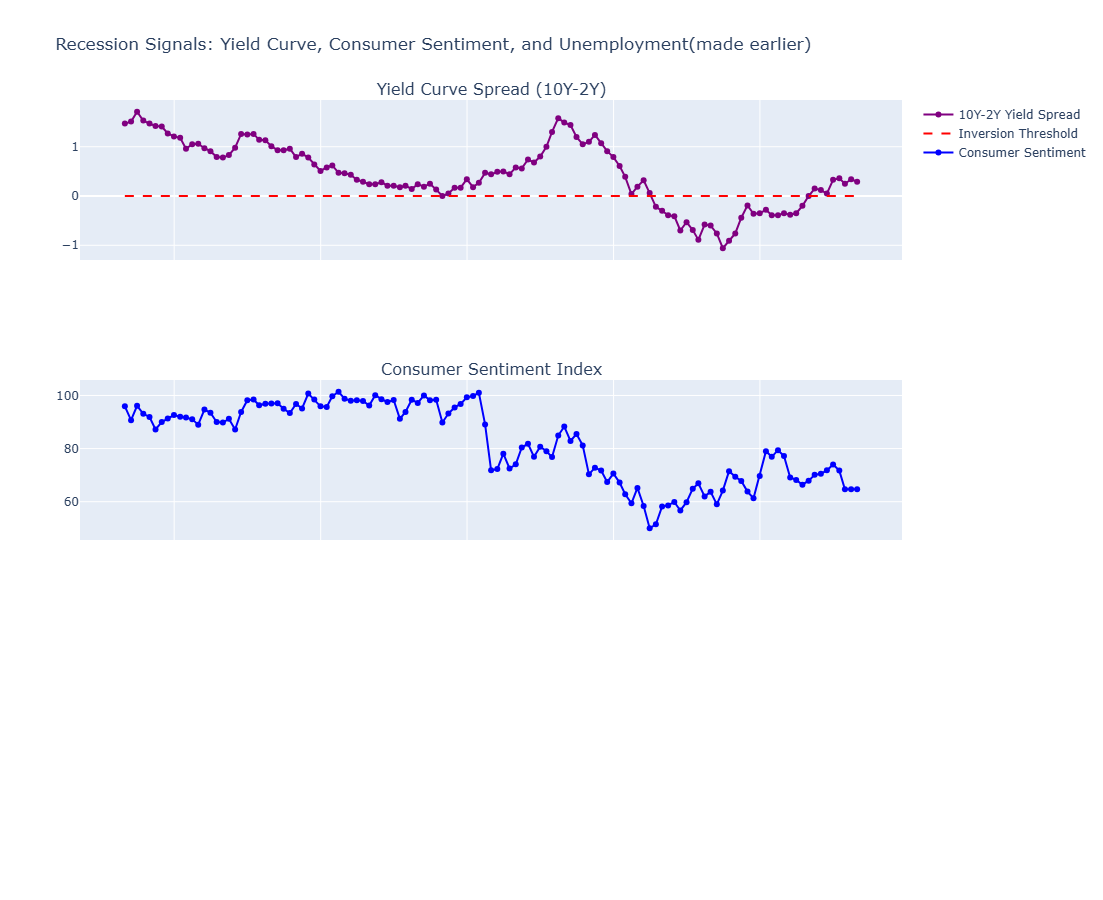

In [4]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load the dataset
file_path = "macro_data.csv"
macro_data = pd.read_csv(file_path)

# Convert DATE column to datetime
macro_data["DATE"] = pd.to_datetime(macro_data["DATE"])


#  Trend Analysis: GDP Growth, Inflation, Unemployment


# Prepare data for each indicator
gdp_growth = macro_data[["DATE", "GDP_Growth_QoQ"]].dropna()
cpi_inflation = macro_data[["DATE", "CPI_YoY"]].dropna()
unemployment = macro_data[["DATE", "UNRATE_UNRATE"]]

# Create subplots for trend analysis
fig_trends = make_subplots(rows=3, cols=1, shared_xaxes=True,
                           subplot_titles=("GDP Growth Rate (QoQ)",
                                           "CPI Inflation Rate (YoY)",
                                           "Unemployment Rate"))

# GDP Growth
fig_trends.add_trace(
    go.Scatter(x=gdp_growth["DATE"], y=gdp_growth["GDP_Growth_QoQ"],
               mode='lines+markers', name='GDP Growth QoQ'),
    row=1, col=1
)
# Zero line for GDP Growth (reference)
fig_trends.add_trace(
    go.Scatter(x=[gdp_growth["DATE"].min(), gdp_growth["DATE"].max()],
               y=[0, 0], mode="lines", line=dict(color="red", dash="dash"),
               name="Zero Line"),
    row=1, col=1
)

# CPI Inflation
fig_trends.add_trace(
    go.Scatter(x=cpi_inflation["DATE"], y=cpi_inflation["CPI_YoY"],
               mode='lines+markers', name='CPI YoY', line=dict(color="orange")),
    row=2, col=1
)

# Unemployment Rate
fig_trends.add_trace(
    go.Scatter(x=unemployment["DATE"], y=unemployment["UNRATE_UNRATE"],
               mode='lines+markers', name='Unemployment Rate', line=dict(color="green")),
    row=3, col=1
)

fig_trends.update_layout(title_text="Trend Analysis: GDP Growth, Inflation, and Unemployment",
                           height=900)
fig_trends.update_xaxes(title_text="Date", row=3, col=1)
fig_trends.show()


# Correlation Analysis: Heatmap of Key Indicators


#key macroeconomic indicators for correlation analysis
corr_columns = [
    "GDP_Growth_QoQ", "CPI_YoY", "UNRATE_UNRATE", "FEDFUNDS_FEDFUNDS", 
    "DGS10_DGS10", "DGS2_DGS2", "T10Y2Y_T10Y2Y", "SP500_SP500", "VIXCLS_VIXCLS", 
    "GFDEBTN_GFDEBTN", "M2SL_M2SL"
]
corr_data = macro_data[corr_columns].dropna()

#correlation matrix
corr_matrix = corr_data.corr()

#correlation heatmap
fig_corr = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale="RdBu",
    zmid=0,
    text=corr_matrix.round(2).values,
    hoverinfo="text"
))
fig_corr.update_layout(title="Correlation Matrix of Key Macroeconomic Indicators",
                       xaxis_nticks=36, height=600)
fig_corr.show()

#-----------------------------------------------------------------------------------------
# Recession Signals: Yield Spread, Consumer Sentiment, Unemployment, we made unemployment earlier


# Prepare data for recession signals
yield_spread = macro_data[["DATE", "T10Y2Y_T10Y2Y"]]
consumer_sentiment = macro_data[["DATE", "UMCSENT_UMCSENT"]]
unemployment = macro_data[["DATE", "UNRATE_UNRATE"]]

# Create subplots for recession signals
fig_recession = make_subplots(rows=3, cols=1, shared_xaxes=True,
                              subplot_titles=("Yield Curve Spread (10Y-2Y)",
                                              "Consumer Sentiment Index",
                                              ))

# Yield Curve Spread
fig_recession.add_trace(
    go.Scatter(x=yield_spread["DATE"], y=yield_spread["T10Y2Y_T10Y2Y"],
               mode="lines+markers", name="10Y-2Y Yield Spread", line=dict(color="purple")),
    row=1, col=1
)
# Zero line for yield spread
fig_recession.add_trace(
    go.Scatter(x=[yield_spread["DATE"].min(), yield_spread["DATE"].max()],
               y=[0, 0], mode="lines", line=dict(color="red", dash="dash"),
               name="Inversion Threshold"),
    row=1, col=1
)

# Consumer Sentiment
fig_recession.add_trace(
    go.Scatter(x=consumer_sentiment["DATE"], y=consumer_sentiment["UMCSENT_UMCSENT"],
               mode="lines+markers", name="Consumer Sentiment", line=dict(color="blue")),
    row=2, col=1
)
#-------ignore---------------------------
# Unemployment Rate
#fig_recession.add_trace(
 #   go.Scatter(x=unemployment["DATE"], y=unemployment["UNRATE_UNRATE"],
  #             mode="lines+markers", name="Unemployment Rate", line=dict(color="green")),
   # row=3, col=1
#)
#-----------------------------------------------------
fig_recession.update_layout(title_text="Recession Signals: Yield Curve, Consumer Sentiment, and Unemployment(made earlier)",
                              height=900)
fig_recession.update_xaxes(title_text="Date", row=3, col=1)
fig_recession.show()

In [ ]:
#arima

In [8]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA


df = pd.read_csv('macro_data.csv', parse_dates=True)

# Display first few rows
print("First 5 rows of the dataset:")
print(df.head())

#print column names for choosing variable
print("\nColumns in the dataset:")
print(df.columns.tolist())

# dataset contains a date column, settin it as the index.

if 'DATE' in df.columns:
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.set_index('DATE', inplace=True)

#our ariable for ARIMA modeling.


ts = df['GDP_GDP'].dropna()  #drop missing values if any

#use the arima model of required order, we will tho use 1,1,1, we can change and see our results if needed
model = ARIMA(ts, order=(1, 1, 1))
model_fit = model.fit()

# Print tabular summary of arima model results
print("\nARIMA Model Summary:")
print(model_fit.summary())


# forecast next 8 periods using arima
forecast_steps = 8
forecast_results = model_fit.get_forecast(steps=forecast_steps)
forecast_df = forecast_results.summary_frame(alpha=0.05)

#display forecast result
print("Forecasted GDP Values for the Next 8 Periods:")
print(forecast_df[['mean', 'mean_ci_lower', 'mean_ci_upper']])



First 5 rows of the dataset:
         DATE    GDP_GDP  GDPC1_GDPC1  GDPPOT_GDPPOT  PCEC_PCEC  \
0  2015-04-30  18279.784    18782.243    18963.01626  12264.140   
1  2015-05-31  18279.784    18782.243    18963.01626  12264.140   
2  2015-06-30  18279.784    18782.243    18963.01626  12264.140   
3  2015-07-31  18401.626    18857.418    19056.83833  12382.494   
4  2015-08-31  18401.626    18857.418    19056.83833  12382.494   

   UNRATE_UNRATE  PAYEMS_PAYEMS  CE16OV_CE16OV  U6RATE_U6RATE  \
0            5.4       141196.0       148511.0           10.9   
1            5.6       141538.0       148817.0           10.9   
2            5.3       141709.0       148816.0           10.4   
3            5.2       141991.0       148830.0           10.3   
4            5.1       142125.0       149181.0           10.2   

   CPIAUCSL_CPIAUCSL  ...  GFDEBTN_GFDEBTN  TOTCI_TOTCI  M2SL_M2SL  \
0            236.222  ...       18151998.0    1852.9063    11937.6   
1            237.001  ...       18151

C:\Users\chour\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

C:\Users\chour\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

C:\Users\chour\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.




ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                GDP_GDP   No. Observations:                  121
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -852.543
Date:                Tue, 08 Apr 2025   AIC                           1711.086
Time:                        01:22:22   BIC                           1719.449
Sample:                    04-30-2015   HQIC                          1714.482
                         - 04-30-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.001   1139.920      0.000       0.998       1.002
ma.L1         -0.9989      0.040    -25.201      0.000      -1.077      -0.921
sigma2      8.599e+04   4.73e-